In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from yellowbrick.model_selection import FeatureImportances

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
random_state = 42

# Цены на мобильные телефоны

### 1. Загрузка и анализ данных, EDA

Загрузка данных по ссылке:

In [4]:
sharing_url = "https://drive.google.com/file/d/1XkKOS6jbke3JYWTj8V_xS46txe820rZ_/view?usp=sharing"
download_url = "https://drive.google.com/uc?id=" + sharing_url.split("/")[-2]

df = pd.read_csv(download_url)

In [5]:
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


Данные находятся в разных шкалах, потребуется нормализация:

In [6]:
df.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


В данных 20 фичей. Boolean фичи (blue, dual_sim, four_g, three_g, touch_screen, wifi) уже были превращены в 0 и 1, поэтому дальнейший препроцессинг не потребуется

In [7]:
df.dtypes

,0
battery_power,int64
blue,int64
clock_speed,float64
dual_sim,int64
fc,int64
four_g,int64
int_memory,int64
m_dep,float64
mobile_wt,int64
n_cores,int64


Пропущенных значений нет:

In [8]:
df.isna().any()

,0
battery_power,False
blue,False
clock_speed,False
dual_sim,False
fc,False
four_g,False
int_memory,False
m_dep,False
mobile_wt,False
n_cores,False


Разделение данных на train и test (val не потребуется, т.к. гиперпараметры будем подбирать кросс-валидацией):

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("price_range", axis=1), df["price_range"],
    test_size=0.1, random_state=random_state
)

data_columns = X_train.columns

Фильтрация данных по VIF (Variance Inflation Factor, фактор инфляции дисперсии), чтобы избежать мультиколлинеарности:

In [10]:
def compute_vif(df):
    df["intercept"] = 1
    vif = pd.DataFrame()
    vif["Variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif = vif[vif["Variable"] != "intercept"]
    df.drop(columns="intercept", inplace=True)
    return vif

Все значения VIF < 5, оставляем все признаки:

In [11]:
compute_vif(X_train).sort_values("VIF", ascending=False)

,Variable,VIF
10,pc,1.731687
4,fc,1.729993
17,three_g,1.534155
5,four_g,1.529907
11,px_height,1.366751
12,px_width,1.357691
14,sc_h,1.354540
15,sc_w,1.351679
1,blue,1.013347
0,battery_power,1.011375


Дисбаланса классов не наблюдается:

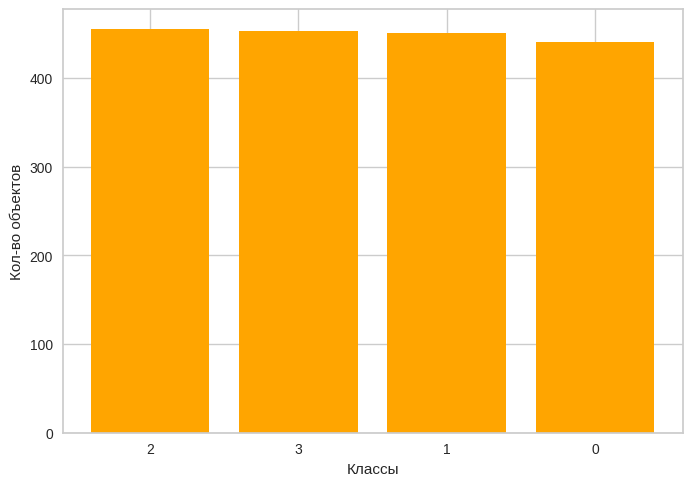

In [12]:
classes = y_train.value_counts().index.astype(str)
num_of_objects = y_train.value_counts()

plt.bar(classes, num_of_objects, color="orange")
plt.xlabel("Классы")
plt.ylabel("Кол-во объектов")
plt.show()

Корреляция Пирсона между характеристиками:

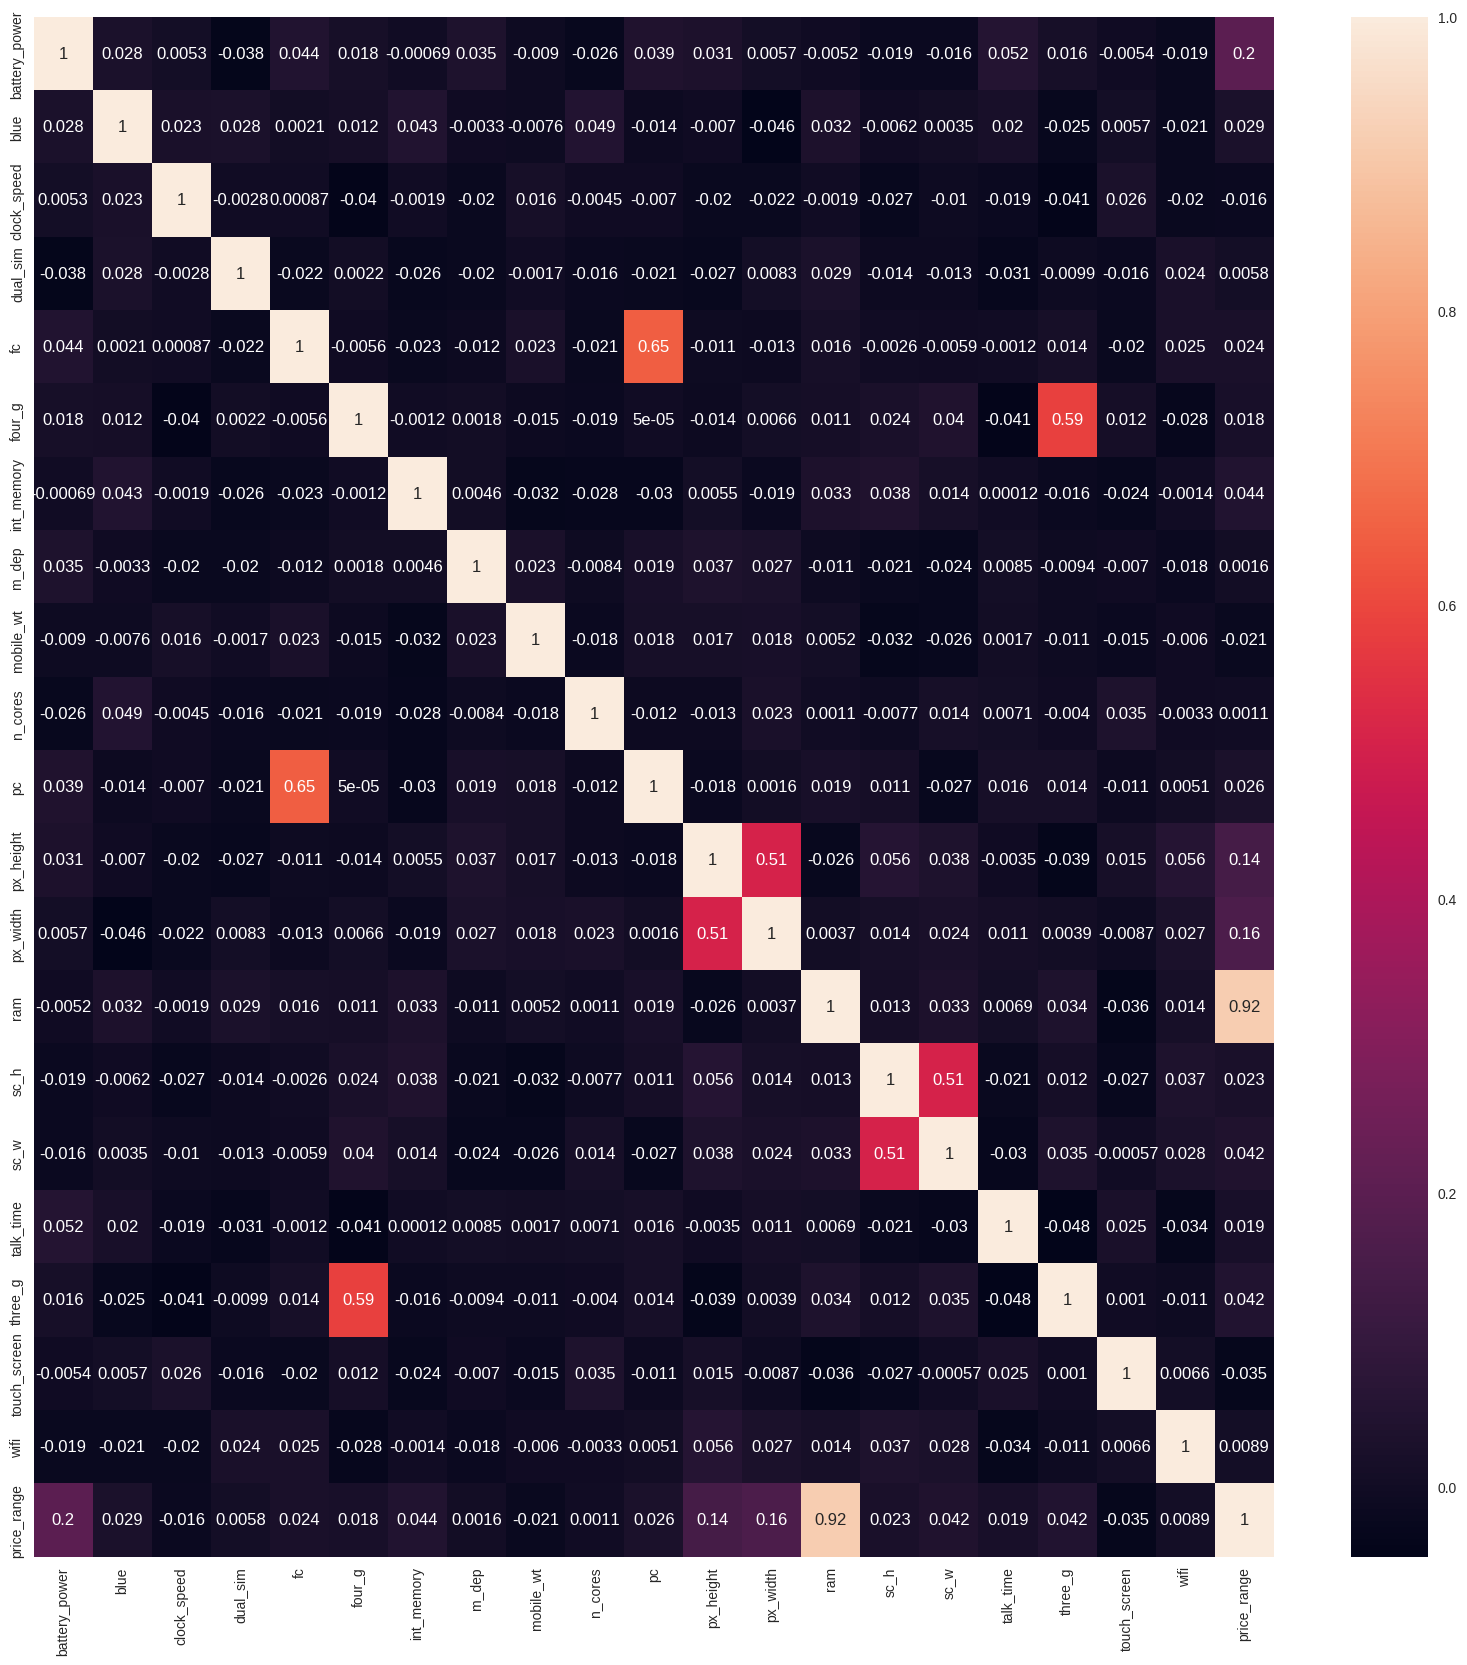

In [13]:
train_corr = pd.concat([X_train, y_train], axis=1).corr()
plt.figure(figsize=(20, 20))
sns.heatmap(train_corr, annot=True);

### 2. Предобработка

Нормализация:

In [14]:
sc = MinMaxScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### 3. Метрики

В качестве метрики для оценки качества моделей используем accuracy (она же microaveraged F1, т.к. классификация не multilabel), так как дисбаланса классов не наблюдается.

### 4. Бейзлайн (logreg)

In [15]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        59
           1       0.93      0.88      0.91        49
           2       0.86      0.84      0.85        45
           3       0.92      0.98      0.95        47

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.92       200
weighted avg       0.93      0.93      0.93       200



Accuracy = 0.93.

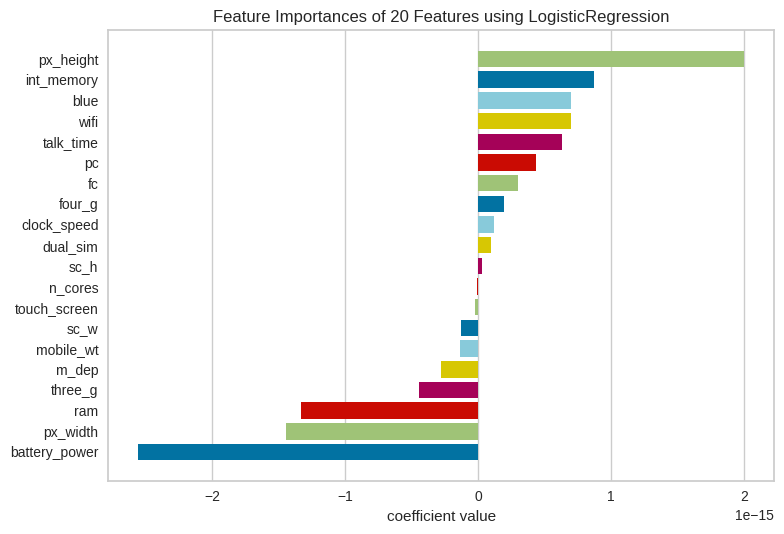

In [16]:
viz = FeatureImportances(lr, labels=data_columns, relative=False)
viz.fit(X_train, y_train)
viz.show();

ram, сильно положительно скоррелированный с target параметр, оказался в importances с отрицательным коэффициентом. 11 из 20 параметров с положительными коэффициентами. Признак, имеющий самый большой по модулю отрицательный коэффициент - battery_power.

### 5. Подбор гиперпараметров для логрега

In [17]:
param_grid = [
    {
        "penalty": ["l1", "l2", "elasticnet", None],
        "C": [1, 10, 100, 1000],
        "solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
    }
]

In [18]:
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy"
)

In [19]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'penalty': ['l1', 'l2', 'elasticnet', None],
                          'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                     'newton-cholesky', 'sag', 'saga']}],
             scoring='accuracy')

In [20]:
for param in grid_search.best_params_:
    print(f"Best {param}: {grid_search.best_params_[param]}")

Best C: 1
Best penalty: None
Best solver: newton-cg


In [21]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        59
           1       0.98      1.00      0.99        49
           2       0.98      0.98      0.98        45
           3       0.98      0.98      0.98        47

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.99      0.98      0.99       200



Accuracy улучшилась до 0.98.

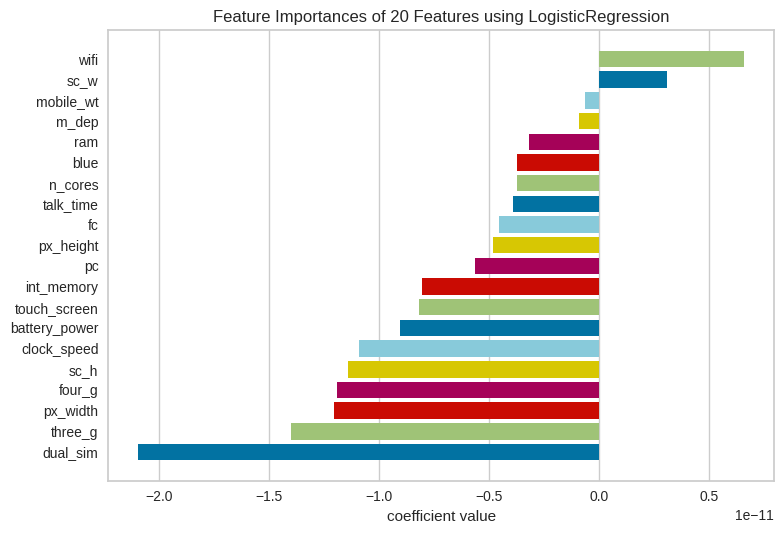

In [22]:
viz = FeatureImportances(best_model, labels=data_columns, relative=False)
viz.fit(X_train, y_train)
viz.show();

После подбора гиперпараметров среди фич с положительными коэффициентами остались только 2: wifi и sc_w. ram по-прежнему с отрицательным коэффициентом, но меньшим по модулю, чем в бейзлайне.

### 6. LGBMClassifier

In [23]:
lgbm_model = LGBMClassifier(verbose=0)
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(verbose=0)

In [24]:
y_pred = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        59
           1       0.88      0.90      0.89        49
           2       0.81      0.84      0.83        45
           3       0.91      0.85      0.88        47

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200



### 7. Подбор гиперпараметров для бустинга

**num_leaves** - максимальное кол-во листьев (неветвящихся элементов) дерева

**max_depth** - максимальная глубина дерева. Если ее не ограничивать, то в листьях в итоге может оказаться по одному элементу (дерево переобучится под шум и выбросы)

**n_estimators** - кол-во деревьев в модели

**min_split_gain** - минимальное приемлемое уменьшение лосса, чтобы разрешить очередное разделение

**min_child_weight** - минимальная сумма гессиана (матрица вторых частных производных лосса) в одном листе, чтобы разрешить очередное разделение

**min_child_samples** - минимальное приемлемое количество элементов в одном листе, чтобы разрешить очередное разделение

**colsample_bytree** - доля признаков, которая будет использована при построении каждого дерева

**subsample** - доля элементов датасета, которая будет использована при построении каждого дерева

In [25]:
param_test ={
    "num_leaves": sp_randint(6, 50),
    "max_depth": sp_randint(2, 10),
    "n_estimators": sp_randint(5, 100),
    "min_split_gain": [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    "min_child_weight": [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    "min_child_samples": sp_randint(10, 500),
    "colsample_bytree": sp_uniform(loc=0.4, scale=0.6),
    "subsample": sp_uniform(loc=0.2, scale=0.8),
    # гиперпараметры L1 и L2 регуляризации
    "reg_alpha": [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    "reg_lambda": [0, 1e-1, 1, 5, 10, 20, 50, 100]
}

In [26]:
grid_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_test,
    n_iter=500,
    scoring="accuracy",
    cv=5,
    random_state=random_state
)

In [ ]:
grid_search_lgbm.fit(X_train, y_train)

In [28]:
for param in grid_search_lgbm.best_params_:
    print(f"Best {param}: {grid_search_lgbm.best_params_[param]}")

Best colsample_bytree: 0.9627791388603365
Best max_depth: 4
Best min_child_samples: 20
Best min_child_weight: 0.001
Best min_split_gain: 1e-06
Best n_estimators: 75
Best num_leaves: 49
Best reg_alpha: 0.1
Best reg_lambda: 1
Best subsample: 0.575285768838063


In [29]:
best_model = grid_search_lgbm.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        59
           1       0.88      0.92      0.90        49
           2       0.83      0.87      0.85        45
           3       0.93      0.87      0.90        47

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.91      0.91      0.91       200



Accuracy увеличилась до 0.91 относительно 0.89.

### 8. Анализ важности признаков

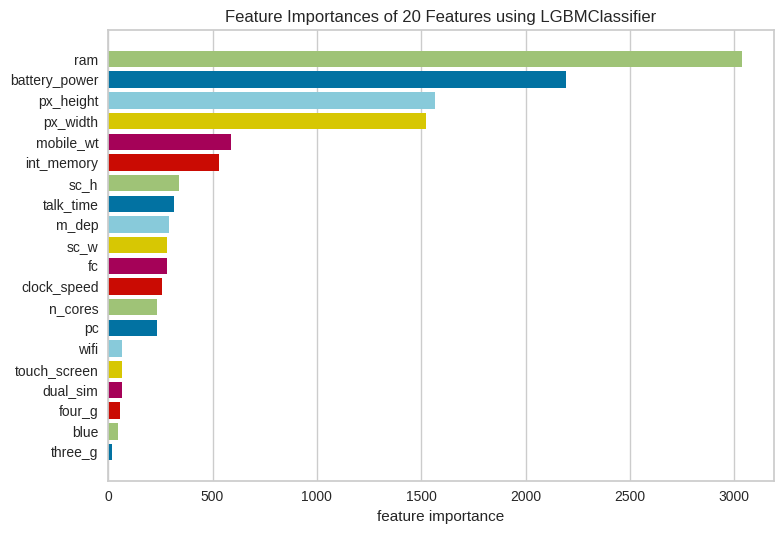

In [30]:
viz = FeatureImportances(lgbm_model, labels=data_columns, relative=False)
viz.fit(X_train, y_train)
viz.show();

В топ-4 самых информативных признаков оказались топ-4 с самой высокой положительной корреляцией с target.

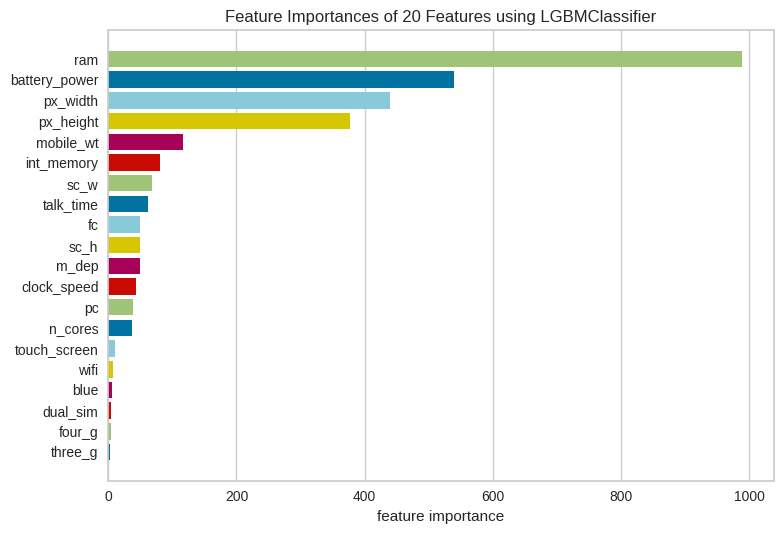

In [31]:
viz = FeatureImportances(grid_search_lgbm.best_estimator_, labels=data_columns, relative=False)
viz.fit(X_train, y_train)
viz.show();

Признаки ранжированы по информативности подобным образом, как в дефолтной модели бустинга. Топ-6 признаков (кроме px_width и px_height у которых близкие по значению коэффициенты) остались на своих местах.

Различия между информативностью для логрега и для бустинга (который по дефолту на решающих деревьях) может быть обоснована следующим:

Коэффициенты у фичей в логреге не должны отражать корреляцию конкретно этой фичи с таргетом, т.к. логрег берет линейную комбинацию ВСЕХ фичей с этими коэффициентами. Коэффициент для каждой фичи отражает влияние фичи на предсказание в совокупности со всеми остальными фичами, а не индивидуально.

Также настолько "хаотичные" результаты у логрега могли получиться из-за наличия корреляции между фичами (визуализация корреляции Пирсона в пункте 1). Эти фичи не были удалены, т.к. мультиколлинеарности не наблюдается (ни один коэффициент корреляции между признаками, не считая таргета, не превышает 0,7; ни одно значение VIF не выше 0.5).

Более того, увеличение кол-ва признаков с отрицательными коэффициентами после подбора гиперпараметров может быть связано с тем, что у "оптимальной" модели нет регуляризации (Best penalty: None), а у дефолтной она есть (L2).

А решающие деревья более устойчивы к мультиколлинеарности, т.к. каждый раз происходит деление по одному признаку.

### 9. Примеры хороших и плохих предсказаний

In [32]:
y_test = y_test.to_numpy()

correct_preds_idx = random.choices(np.argwhere(y_test == y_pred).squeeze(), k=5)
incorrect_preds_idx = random.choices(np.argwhere(y_test != y_pred).squeeze(), k=5)

df_test = pd.DataFrame(X_test, columns=data_columns)

Плохие предсказания:

In [33]:
for i in range(5):
    print(f"Correct item: {y_test[incorrect_preds_idx[i]]}")
    print(f"But the boosting model predicted {y_pred[incorrect_preds_idx[i]]}")
    print(incorrect_preds_idx[i])
    print(df_test.iloc[incorrect_preds_idx[i]])
    print()

Correct item: 2
But the boosting model predicted 1
21
battery_power    0.525718
blue             0.000000
clock_speed      0.000000
dual_sim         1.000000
fc               0.157895
four_g           1.000000
int_memory       0.951613
m_dep            0.111111
mobile_wt        0.291667
n_cores          0.714286
pc               0.300000
px_height        0.504082
px_width         0.669559
ram              0.434527
sc_h             0.785714
sc_w             0.333333
talk_time        0.444444
three_g          1.000000
touch_screen     0.000000
wifi             1.000000
Name: 21, dtype: float64

Correct item: 3
But the boosting model predicted 2
57
battery_power    0.927856
blue             0.000000
clock_speed      0.240000
dual_sim         0.000000
fc               0.210526
four_g           1.000000
int_memory       0.741935
m_dep            0.444444
mobile_wt        0.391667
n_cores          0.428571
pc               0.250000
px_height        0.733673
px_width         0.889186
ram     

Хорошие предсказания:

In [34]:
for i in range(5):
    print(f"Correct item: {y_test[correct_preds_idx[i]]}")
    print(f"The boosting model predicted {y_pred[correct_preds_idx[i]]}")
    print(correct_preds_idx[i])
    print(df_test.iloc[correct_preds_idx[i]])
    print()

Correct item: 3
The boosting model predicted 3
66
battery_power    0.792919
blue             0.000000
clock_speed      0.800000
dual_sim         0.000000
fc               0.000000
four_g           1.000000
int_memory       0.306452
m_dep            0.111111
mobile_wt        0.750000
n_cores          0.857143
pc               0.000000
px_height        0.331633
px_width         0.242991
ram              0.996259
sc_h             0.857143
sc_w             0.777778
talk_time        0.333333
three_g          1.000000
touch_screen     1.000000
wifi             1.000000
Name: 66, dtype: float64

Correct item: 0
The boosting model predicted 0
64
battery_power    0.078156
blue             1.000000
clock_speed      0.200000
dual_sim         0.000000
fc               0.473684
four_g           1.000000
int_memory       0.177419
m_dep            0.000000
mobile_wt        0.000000
n_cores          0.428571
pc               0.750000
px_height        0.301531
px_width         0.149533
ram             

### 10. Метрики

Самой лучшей моделью оказалась логистическая регрессия с подобранными гиперпараметрами, показавшая accuracy = 0.98. Она оказалась лучше бейзлайна со значением accuracy 0.94.

Бустинг даже после подбора гиперпараметров продолжил переобучаться под трейн, и максимальное значение accuracy, достигнутое с помощью него, не превысило бейзлайн.

Вывод: отношение между фичами и таргетом достаточно простое, чтобы хорошо генерализоваться логрегом. Бустинг - это пушка по воробьям

Логрег бейзлайн: 0.94

Логрег после подбора гиперпараметров: 0.98

LGBMClassifier: 0.89

LGBMClassifier после подбора гиперпараметров: 0.91

# Показания пожарного датчика

### 11. Загрузка и анализ данных, EDA

Загрузка данных по ссылке:

In [35]:
sharing_url = "https://drive.google.com/file/d/1TJI9IVaZQtaTJUezLrC3WaQ-eEC40AGG/view?usp=sharing"
download_url = "https://drive.google.com/uc?id=" + sharing_url.split("/")[-2]

df = pd.read_csv(download_url)

In [36]:
df.head()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


Данные находятся в разных шкалах, потребуется нормализация:

In [37]:
df.describe()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
count,62630.000000,6.263000e+04,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000
mean,31314.500000,1.654792e+09,15.970424,48.539499,1942.057528,670.021044,12942.453936,19754.257912,938.627649,100.594309,184.467770,491.463608,203.586487,80.049042,10511.386157,0.714626
std,18079.868017,1.100025e+05,14.359576,8.865367,7811.589055,1905.885439,272.464305,609.513156,1.331344,922.524245,1976.305615,4265.661251,2214.738556,1083.383189,7597.870997,0.451596
min,0.000000,1.654712e+09,-22.010000,10.740000,0.000000,400.000000,10668.000000,15317.000000,930.852000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15657.250000,1.654743e+09,10.994250,47.530000,130.000000,400.000000,12830.000000,19435.000000,938.700000,1.280000,1.340000,8.820000,1.384000,0.033000,3625.250000,0.000000
50%,31314.500000,1.654762e+09,20.130000,50.150000,981.000000,400.000000,12924.000000,19501.000000,938.816000,1.810000,1.880000,12.450000,1.943000,0.044000,9336.000000,1.000000
75%,46971.750000,1.654778e+09,25.409500,53.240000,1189.000000,438.000000,13109.000000,20078.000000,939.418000,2.090000,2.180000,14.420000,2.249000,0.051000,17164.750000,1.000000
max,62629.000000,1.655130e+09,59.930000,75.200000,60000.000000,60000.000000,13803.000000,21410.000000,939.861000,14333.690000,45432.260000,61482.030000,51914.680000,30026.438000,24993.000000,1.000000


Типы всех колонок числовые:

In [38]:
df.dtypes

,0
Unnamed: 0,int64
UTC,int64
Temperature[C],float64
Humidity[%],float64
TVOC[ppb],int64
eCO2[ppm],int64
Raw H2,int64
Raw Ethanol,int64
Pressure[hPa],float64
PM1.0,float64


Пропущенных значений нет:

In [39]:
df.isna().any()

,0
Unnamed: 0,False
UTC,False
Temperature[C],False
Humidity[%],False
TVOC[ppb],False
eCO2[ppm],False
Raw H2,False
Raw Ethanol,False
Pressure[hPa],False
PM1.0,False


In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("Fire Alarm", axis=1), df["Fire Alarm"],
    test_size=0.1, random_state=random_state
)

У пяти характеристик огромные значения VIF:

In [41]:
compute_vif(X_train).sort_values("VIF", ascending=False)

,Variable,VIF
12,NC1.0,1.634404e+12
13,NC2.5,6.341312e+11
10,PM2.5,4.591761e+11
9,PM1.0,9.658573e+10
11,NC0.5,6.860955e+10
7,Raw Ethanol,9.914382e+00
4,TVOC[ppb],5.975057e+00
14,CNT,4.267418e+00
0,Unnamed: 0,3.924749e+00
6,Raw H2,3.356213e+00


В данных наблюдается дисбаланс классов: случаев, когда датчик сработал (1), более чем в 2 раза превышает количество случаев, когда он не сработал (0):

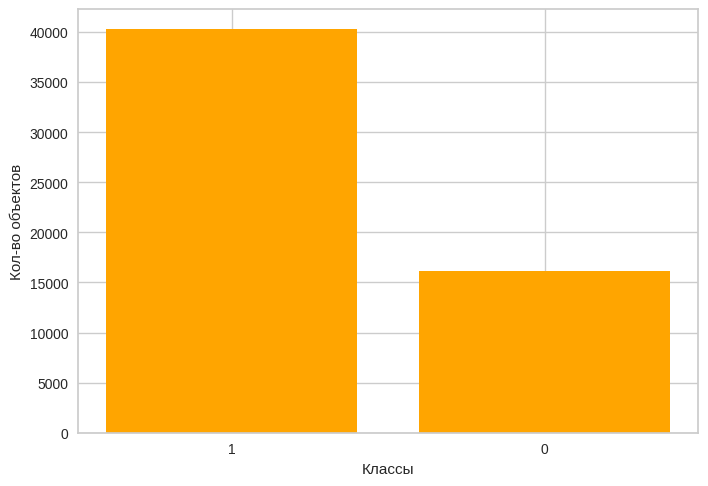

In [42]:
classes = y_train.value_counts().index.astype(str)
num_of_objects = y_train.value_counts()

plt.bar(classes, num_of_objects, color="orange")
plt.xlabel("Классы")
plt.ylabel("Кол-во объектов")
plt.show()

Корреляция Пирсона между характеристиками:

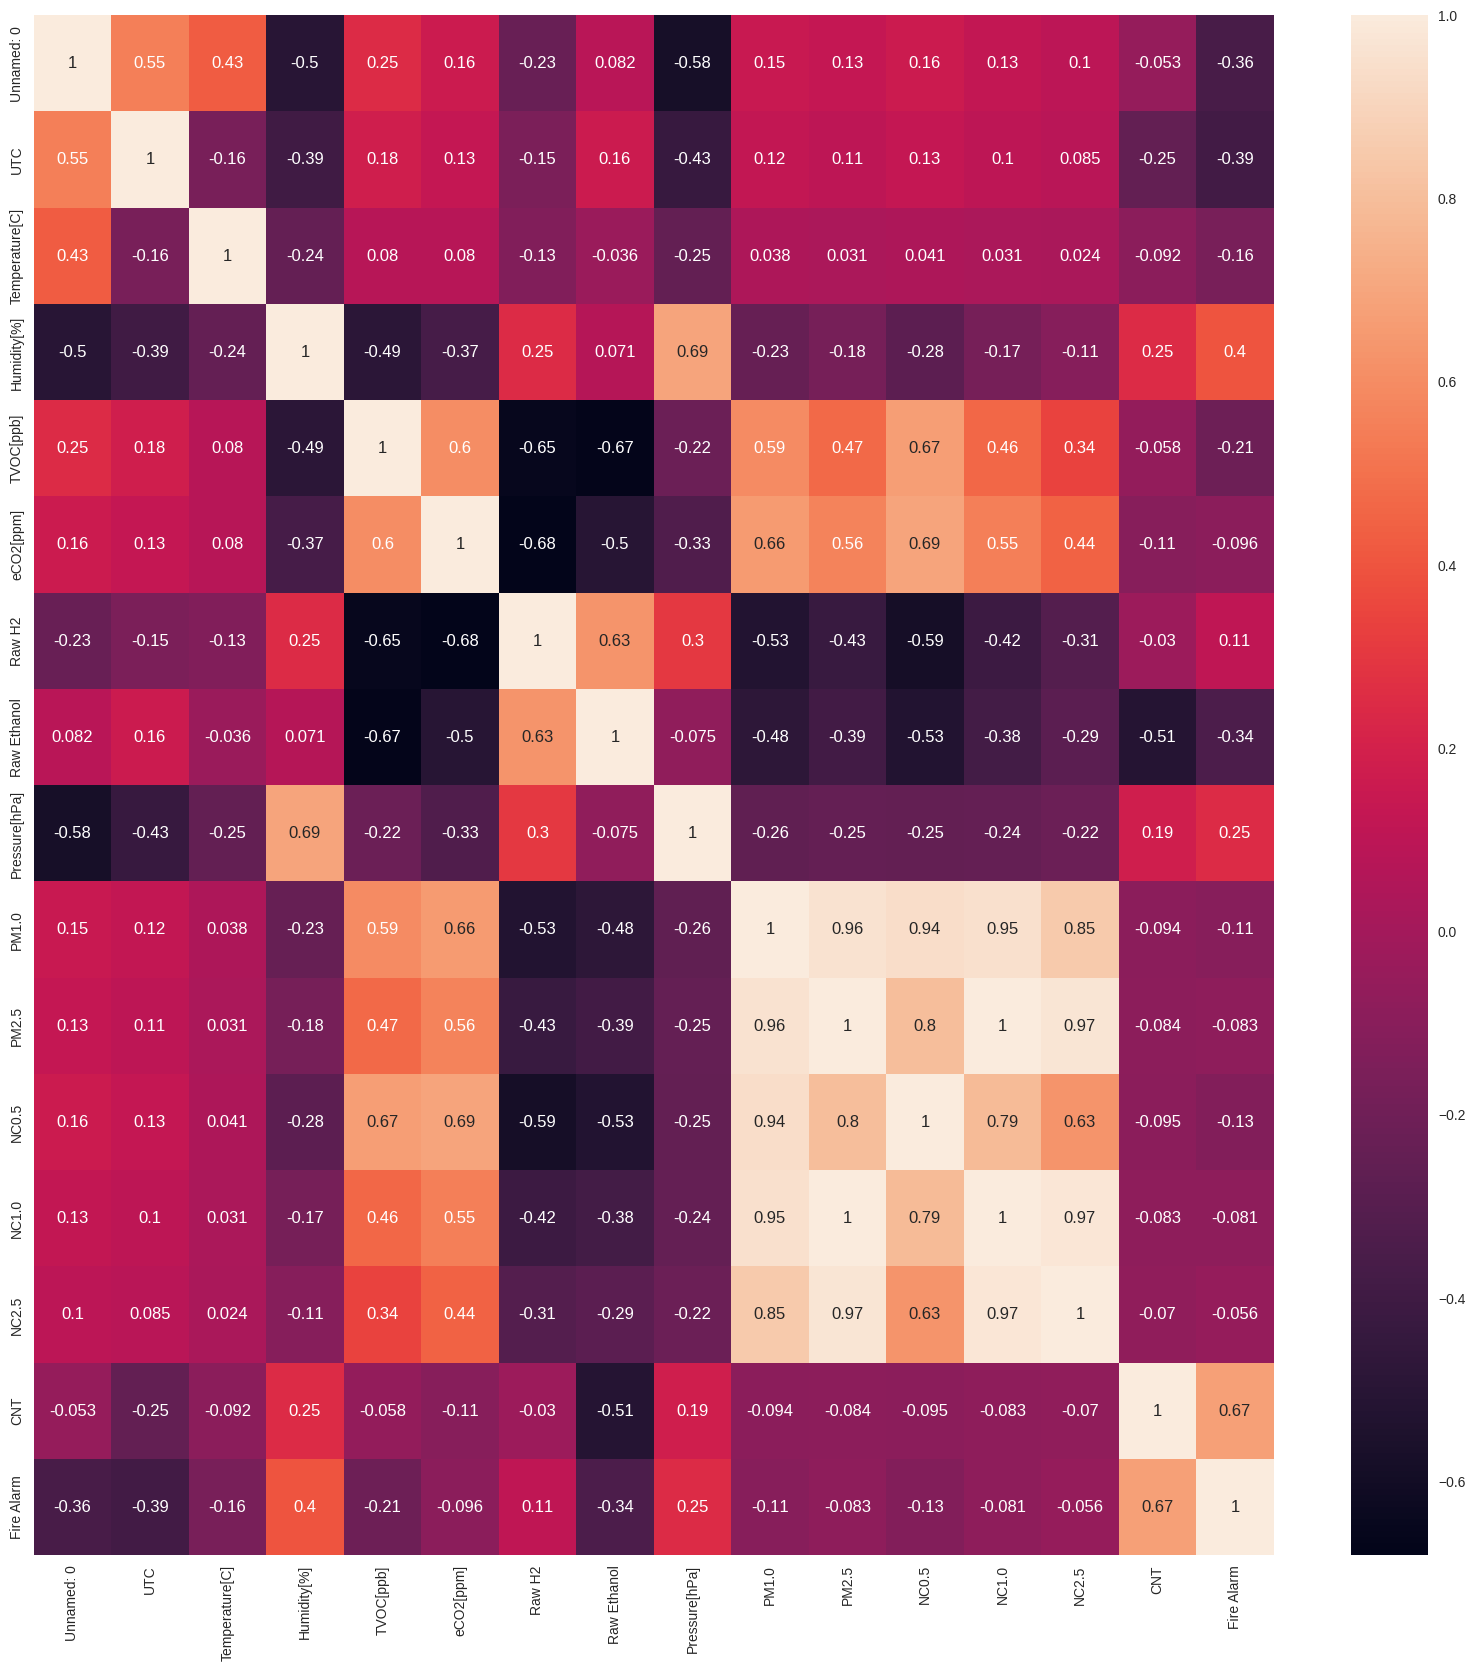

In [43]:
train_corr = pd.concat([X_train, y_train], axis=1).corr()
plt.figure(figsize=(20, 20))
sns.heatmap(train_corr, annot=True);

Есть сильно коррелирующие между собой характеристики, которые нужно будет удалить.

### 12. Предобработка

Преобразуем время в формат datetime:

In [44]:
def transform_utc_to_date_time(df):
    df["UTC"] = pd.to_datetime(df["UTC"], unit="s", utc=True)

    df["year"] = df["UTC"].dt.year
    df["month"] = df["UTC"].dt.month
    df["dayofweek"] = df["UTC"].dt.dayofweek
    df["day"] = df["UTC"].dt.day
    df["hour"] = df["UTC"].dt.hour
    df["minute"] = df["UTC"].dt.minute
    df["second"] = df["UTC"].dt.second
    df["quarter"] = df["UTC"].dt.quarter

    df.drop(columns="UTC", inplace=True)
    return df

In [45]:
X_train = transform_utc_to_date_time(X_train)
X_test = transform_utc_to_date_time(X_test)

In [46]:
X_train.describe()

,Unnamed: 0,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,...,NC2.5,CNT,year,month,dayofweek,day,hour,minute,second,quarter
count,56367.000000,56367.000000,56367.000000,56367.000000,56367.000000,56367.000000,56367.000000,56367.000000,56367.000000,56367.000000,...,56367.000000,56367.000000,56367.0,56367.0,56367.000000,56367.000000,56367.000000,56367.000000,56367.000000,56367.0
mean,31306.103394,15.947584,48.544981,1941.786418,671.320737,12942.417744,19753.978658,938.628662,100.413222,183.989132,...,79.762674,10516.798765,2022.0,6.0,2.652687,9.291997,8.916299,29.503078,29.536910,2.0
std,18066.464219,14.378731,8.866481,7816.165037,1923.165066,272.755706,609.452752,1.330508,919.541569,1971.260333,...,1081.227101,7604.994710,0.0,0.0,0.900820,1.219083,5.655404,17.109678,17.338633,0.0
min,0.000000,-22.010000,10.740000,0.000000,400.000000,10668.000000,15317.000000,930.852000,0.000000,0.000000,...,0.000000,0.000000,2022.0,6.0,0.000000,8.000000,0.000000,0.000000,0.000000,2.0
25%,15719.500000,10.951500,47.530000,128.000000,400.000000,12830.000000,19435.000000,938.700000,1.290000,1.340000,...,0.033000,3619.000000,2022.0,6.0,3.000000,9.000000,4.000000,15.000000,15.000000,2.0
50%,31282.000000,20.127000,50.150000,981.000000,400.000000,12924.000000,19501.000000,938.816000,1.810000,1.880000,...,0.044000,9341.000000,2022.0,6.0,3.000000,9.000000,9.000000,29.000000,30.000000,2.0
75%,46930.500000,25.410000,53.240000,1189.000000,438.000000,13109.000000,20079.000000,939.419000,2.100000,2.180000,...,0.051000,17195.500000,2022.0,6.0,3.000000,9.000000,13.000000,44.000000,45.000000,2.0
max,62629.000000,59.930000,75.200000,60000.000000,60000.000000,13803.000000,21410.000000,939.861000,14333.690000,45432.260000,...,30026.438000,24993.000000,2022.0,6.0,4.000000,13.000000,23.000000,59.000000,59.000000,2.0


Удалим ненужные характеристики (индексы) и константные характеристики, получившиеся в результате feature engineering (год, квартал и месяц):

In [47]:
X_train.drop(columns=["Unnamed: 0", "CNT", "year", "quarter", "month"], inplace=True)

Итеративно отбросим характеристики с VIF > 5:

In [48]:
df_vif = compute_vif(X_train)
max_vif = df_vif["VIF"].max()

while max_vif > 5:
    feature_to_drop_idx = df_vif["VIF"].idxmax()
    feature_name = df_vif.iloc[feature_to_drop_idx]["Variable"]
    print(f"Dropping {feature_name} with VIF = {max_vif}")
    X_train.drop(columns=feature_name, inplace=True)
    df_vif = compute_vif(X_train)
    max_vif = df_vif["VIF"].max()

Dropping NC1.0 with VIF = 1632626292322.094
Dropping PM2.5 with VIF = 333958668745.7266
Dropping PM1.0 with VIF = 65546946896.58404
Dropping dayofweek with VIF = 7.501070868718823


In [49]:
compute_vif(X_train).sort_values("VIF", ascending=False)

,Variable,VIF
2,TVOC[ppb],4.324620
6,Pressure[hPa],3.610932
1,Humidity[%],3.423143
7,NC0.5,3.285832
4,Raw H2,3.095592
5,Raw Ethanol,2.958825
10,hour,2.864397
3,eCO2[ppm],2.691664
0,Temperature[C],1.886269
8,NC2.5,1.754249


In [50]:
X_test.drop(
    columns=[
        "Unnamed: 0", "CNT", "year", "quarter",
        "month", "NC1.0", "PM2.5", "PM1.0", "dayofweek"
    ],
    inplace=True
)
data_columns = X_test.columns

Нормализация:

In [51]:
sc = MinMaxScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### 13. Метрики

Самая важная метрика для этой задачи - recall, так как false negative опасны (случился пожар, а датчик не сработал). При этом нужно поддерживать высокий уровень precision (иначе можно было бы использовать наивный классификатор, триггерящий датчик при любых условиях). Нужное соотношение precision и recall можно определить через ROC-кривую. Следдовательно, максимизируем ROC-AUC.

### 14. Бейзлайн (logreg)

In [52]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [53]:
def roc_results(model, X_test, y_test):
    pred_probas = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, pred_probas)
    plt.plot(fpr, tpr)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC curve")
    plt.show()
    print("ROC-AUC =", "%.4f" % roc_auc_score(y_test, pred_probas))
    return fpr, tpr, thresholds

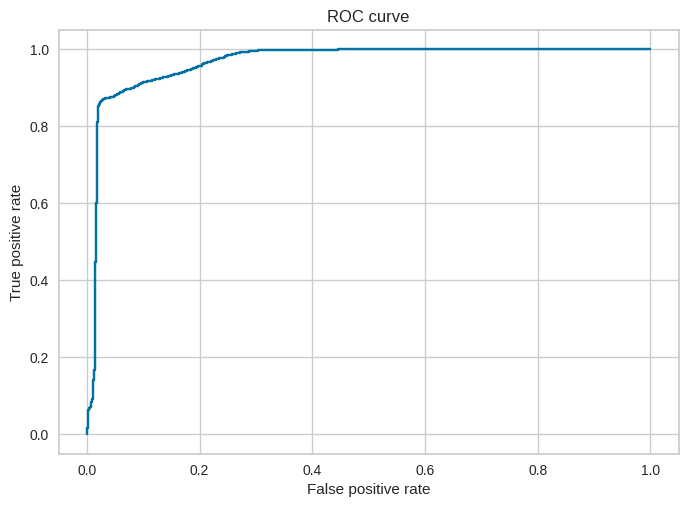

ROC-AUC = 0.9672


In [54]:
fpr, tpr, thresholds = roc_results(lr, X_test, y_test)

Так как ложноотрицательные результаты опасны, необходимо поставить такой трешхолд, где true positive rate очень высокая.
Примем, что минимально приемлемый recall (TPR) = 0.999

In [55]:
idx = [n for n, i in enumerate(tpr) if i >= 0.999][0]
print(f"Оптимальный трешхолд: {thresholds[idx]:.4f}; TPR = {tpr[idx]:.4f}, FPR = {fpr[idx]:.4f}")

Оптимальный трешхолд: 0.2809; TPR = 0.9991, FPR = 0.3236


In [56]:
y_pred = (lr.predict_proba(X_test)[:, 1] >= thresholds[idx])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.68      0.81      1774
           1       0.89      1.00      0.94      4489

    accuracy                           0.91      6263
   macro avg       0.94      0.84      0.87      6263
weighted avg       0.92      0.91      0.90      6263



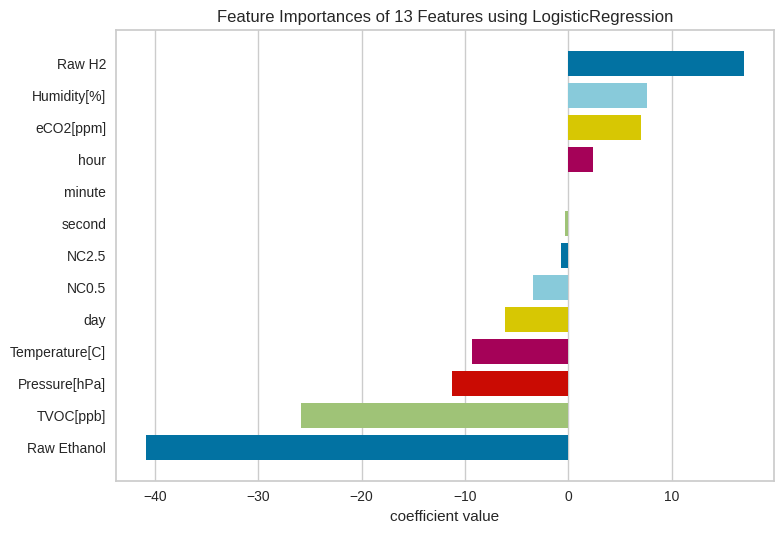

In [57]:
viz = FeatureImportances(lr, labels=data_columns, relative=False)
viz.fit(X_train, y_train)
viz.show();

Самыми информативными признаками стали содержание водорода (с положительным коэффициентом) и содержание этанола (с отрицательным коэффициентом). Маленькие по модулю коэффициенты у "временных" фичей, полученных в результате feature engineering.

### 15. Подбор гиперпараметров для логрега

In [58]:
param_grid = [
    {
        "penalty": ["l1", "l2", "elasticnet", None],
        "C": [1, 10, 100, 1000],
        "solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
    }
]

In [59]:
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc"
)

In [60]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'penalty': ['l1', 'l2', 'elasticnet', None],
                          'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                     'newton-cholesky', 'sag', 'saga']}],
             scoring='roc_auc')

In [61]:
for param in grid_search.best_params_:
    print(f"Best {param}: {grid_search.best_params_[param]}")

Best C: 1
Best penalty: None
Best solver: newton-cholesky


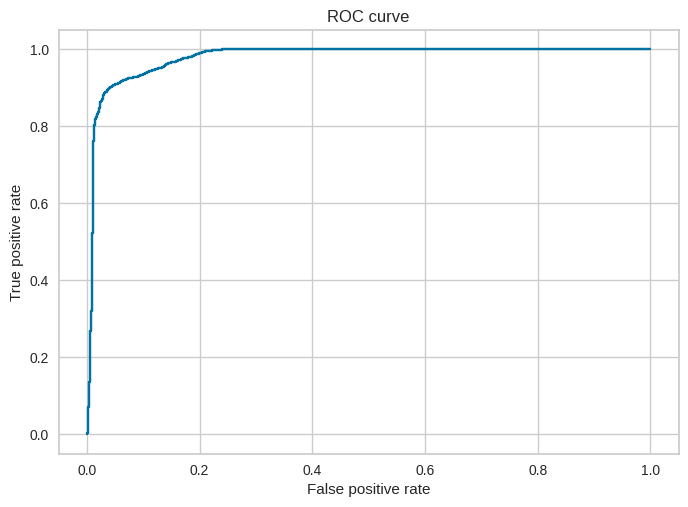

ROC-AUC = 0.9786


In [62]:
best_model = grid_search.best_estimator_
fpr, tpr, thresholds = roc_results(best_model, X_test, y_test)

Аналогично найдем оптимальный трешхолд:

In [63]:
idx = [n for n, i in enumerate(tpr) if i >= 0.999][0]
print(f"Оптимальный трешхолд: {thresholds[idx]:.4f}; TPR = {tpr[idx]:.4f}, FPR = {fpr[idx]:.4f}")

Оптимальный трешхолд: 0.2407; TPR = 0.9991, FPR = 0.2317


In [64]:
y_pred = (best_model.predict_proba(X_test)[:, 1] >= thresholds[idx])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87      1774
           1       0.92      1.00      0.96      4489

    accuracy                           0.93      6263
   macro avg       0.96      0.88      0.91      6263
weighted avg       0.94      0.93      0.93      6263



Precision для класса 1 и recall для класса 0 улучшились:

0.89 -> 0.92

и 0.68 -> 0.77 соответственно.

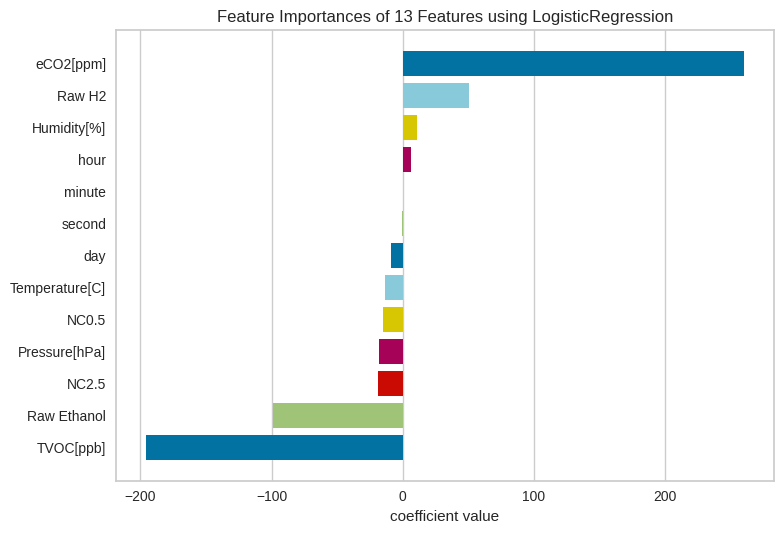

In [65]:
viz = FeatureImportances(best_model, labels=data_columns, relative=False)
viz.fit(X_train, y_train)
viz.show();

После подбора гиперпараметров среди самых информативных характеристик с положительными коэффициентами содержание водорода опустилось на второе место; первое место заняла концентрация углекислого газа (что имеет больше всего смысла).

Среди самых больших по модулю отрицательных коэффициентов содержание этанола опустилось на второе место; первое место заняло содержание летучих органических веществ (что контринтуитивно, т.к. при пожаре их концентрация в воздухе увеличивается).

Маленькие по модулю коэффициенты аналогично у "временных" фичей, полученных в результате feature engineering.

### 16. LGBMClassifier

In [66]:
lgbm_model = LGBMClassifier(verbose=0)
lgbm_model.fit(X_train, y_train)

LGBMClassifier(verbose=0)

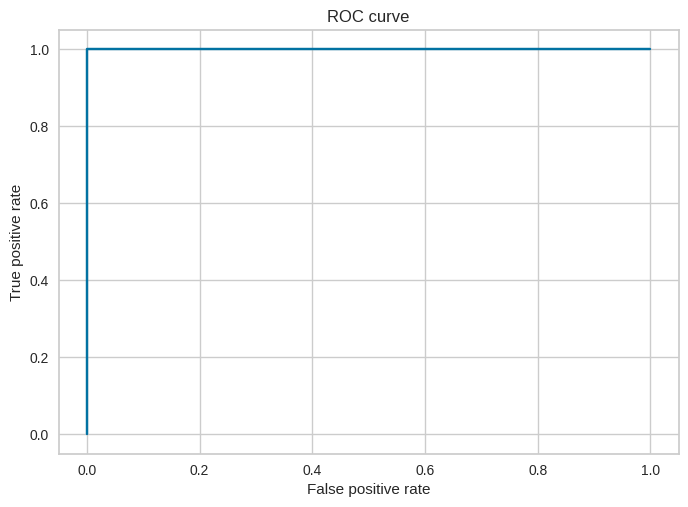

ROC-AUC = 1.0000


In [67]:
fpr, tpr, thresholds = roc_results(lgbm_model, X_test, y_test)

In [68]:
idx = [n for n, i in enumerate(tpr) if i > 0.999][0]
print(f"Оптимальный трешхолд: {thresholds[idx]:.4f}; TPR = {tpr[idx]:.4f}, FPR = {fpr[idx]:.4f}")

Оптимальный трешхолд: 0.9967; TPR = 1.0000, FPR = 0.0000


In [69]:
y_pred = (lgbm_model.predict_proba(X_test)[:, 1] >= thresholds[idx])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1774
           1       1.00      1.00      1.00      4489

    accuracy                           1.00      6263
   macro avg       1.00      1.00      1.00      6263
weighted avg       1.00      1.00      1.00      6263



Дефолтный бустинг оказался идеальным классификатором.

### 17. Подбор гиперпараметров для бустинга

**num_leaves** - максимальное кол-во листьев (неветвящихся элементов) дерева

**max_depth** - максимальная глубина дерева. Если ее не ограничивать, то в листьях в итоге может оказаться по одному элементу (дерево переобучится под шум и выбросы)

**n_estimators** - кол-во деревьев в модели

**min_split_gain** - минимальное приемлемое уменьшение лосса, чтобы разрешить очередное разделение

**min_child_weight** - минимальная сумма гессиана (матрица вторых частных производных лосса) в одном листе, чтобы разрешить очередное разделение

**min_child_samples** - минимальное приемлемое количество элементов в одном листе, чтобы разрешить очередное разделение

**colsample_bytree** - доля признаков, которая будет использована при построении каждого дерева

**subsample** - доля элементов датасета, которая будет использована при построении каждого дерева

In [70]:
param_test ={
    "num_leaves": sp_randint(6, 50),
    "max_depth": sp_randint(2, 10),
    "n_estimators": sp_randint(5, 100),
    "min_split_gain": [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    "min_child_weight": [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    "min_child_samples": sp_randint(10, 500),
    "colsample_bytree": sp_uniform(loc=0.4, scale=0.6),
    "subsample": sp_uniform(loc=0.2, scale=0.8),
    # гиперпараметры L1 и L2 регуляризации
    "reg_alpha": [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    "reg_lambda": [0, 1e-1, 1, 5, 10, 20, 50, 100]
}

In [71]:
grid_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_test,
    n_iter=20,
    scoring="roc_auc",
    cv=5,
    random_state=random_state
)

In [ ]:
grid_search_lgbm.fit(X_train, y_train)

In [73]:
for param in grid_search_lgbm.best_params_:
    print(f"Best {param}: {grid_search_lgbm.best_params_[param]}")

Best colsample_bytree: 0.5870266456536466
Best max_depth: 7
Best min_child_samples: 63
Best min_child_weight: 0.1
Best min_split_gain: 0.01
Best n_estimators: 97
Best num_leaves: 23
Best reg_alpha: 0.1
Best reg_lambda: 0.1
Best subsample: 0.915861880342119


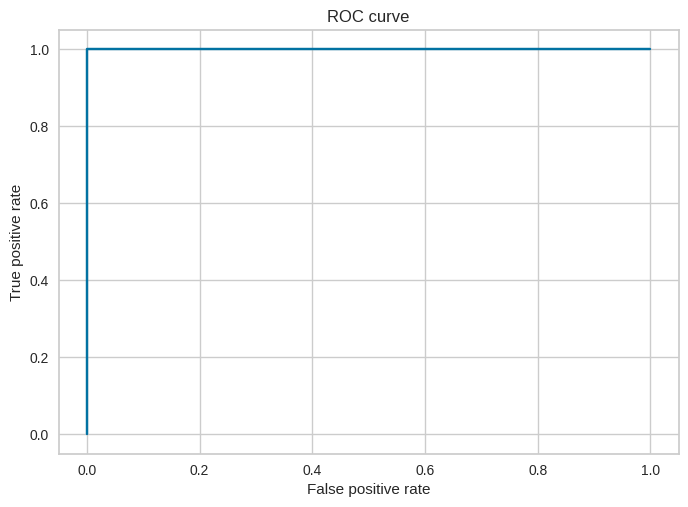

ROC-AUC = 1.0000


In [74]:
fpr, tpr, thresholds = roc_results(grid_search_lgbm.best_estimator_, X_test, y_test)

In [75]:
idx = [n for n, i in enumerate(tpr) if i >= 0.999][0]
print(f"Оптимальный трешхолд: {thresholds[idx]:.4f}; TPR = {tpr[idx]:.4f}, FPR = {fpr[idx]:.4f}")

Оптимальный трешхолд: 0.9739; TPR = 1.0000, FPR = 0.0000


In [76]:
y_pred = (grid_search_lgbm.best_estimator_.predict_proba(X_test)[:, 1] >= thresholds[idx])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1774
           1       1.00      1.00      1.00      4489

    accuracy                           1.00      6263
   macro avg       1.00      1.00      1.00      6263
weighted avg       1.00      1.00      1.00      6263



### 18. Анализ важности признаков

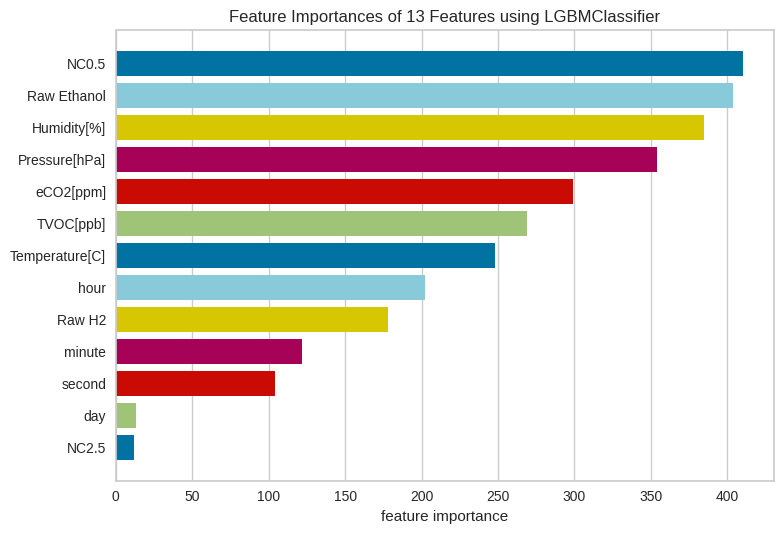

In [77]:
viz = FeatureImportances(lgbm_model, labels=data_columns, relative=False)
viz.fit(X_train, y_train)
viz.show();

Самым информативным признаком стал NC0.5 (который был малоинформативным для обеих логрегов). Содержание этанола (бывшее информативным для логрегов) оказалось на втором месте. Третье и четвертое место заняли влажность и давление (которые были достаточно информативны для первого логрега, но малоинформативны для второго). Временные характеристики оказались во второй половине по информативности.

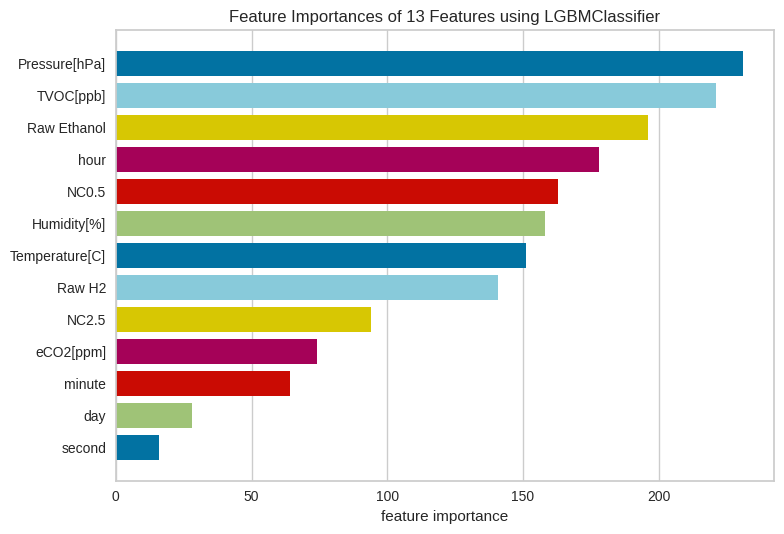

In [78]:
viz = FeatureImportances(grid_search_lgbm.best_estimator_, labels=data_columns, relative=False)
viz.fit(X_train, y_train)
viz.show();

Важности признаков переранжировались: на 1 месте оказалось давление (которое было на 4 месте у дефолтного дерева); на 2 - содержание летучих органических веществ (которое было на 6); содержание этанола переместилось со 2 места на 3; час оказался достаточно информативным признаком и попал в топ-4.

### 19. Примеры хороших и плохих предсказаний

In [79]:
y_test = y_test.to_numpy()
correct_preds_idx = random.choices(np.argwhere(y_test == y_pred).squeeze(), k=5)
df_test = pd.DataFrame(X_test, columns=data_columns)

Есть только хорошие предсказания:

In [80]:
for i in range(5):
    print(f"Correct item: {y_test[correct_preds_idx[i]]}")
    print(f"The boosting model predicted {y_pred[correct_preds_idx[i]]}")
    print(correct_preds_idx[i])
    print(df_test.iloc[correct_preds_idx[i]])
    print()

Correct item: 1
The boosting model predicted True
5900
Temperature[C]    0.155419
Humidity[%]       0.674217
TVOC[ppb]         0.000000
eCO2[ppm]         0.000000
Raw H2            0.834131
Raw Ethanol       0.811751
Pressure[hPa]     0.985570
NC0.5             0.000279
NC2.5             0.000002
day               0.200000
hour              0.043478
minute            0.677966
second            0.898305
Name: 5900, dtype: float64

Correct item: 1
The boosting model predicted True
4470
Temperature[C]    0.558579
Humidity[%]       0.676233
TVOC[ppb]         0.016700
eCO2[ppm]         0.004513
Raw H2            0.676555
Raw Ethanol       0.681930
Pressure[hPa]     0.911422
NC0.5             0.000255
NC2.5             0.000002
day               0.200000
hour              0.434783
minute            0.932203
second            0.864407
Name: 4470, dtype: float64

Correct item: 1
The boosting model predicted True
5178
Temperature[C]    0.556993
Humidity[%]       0.616196
TVOC[ppb]         0.012

### 20. Метрики

Логистической регрессии было недостаточно, чтобы генерализоваться под этот датасет: при ограничении на recall >= 0.999, precision для класса 1 и recall для класса 0 достигли только:

0.89 и 0.68 соответственно для дефолтного логрега;

0.92 и 0.77 соответственно для логрега с подобранными гиперпараметрами.

Бустинг же стал идеальным классификатором даже без подбора гиперпараметров и достиг 1 по всем метрикам.